In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
path_dir = 'C:\\Users\\kumapank\\Documents\\COVID-19\\'

# Read Master Data

In [3]:
%%time
mst_df = pd.read_csv(path_dir+'\\output\\Covid19_master_dataV1.csv')
mst_df.head()

Wall time: 93.7 ms


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case,Growth_Factor,Country Code,density_2018,Demography_2018,DrRatio,PatientBed
0,"Adams, IN",US,39.8522,-77.2865,2020-03-19,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
1,"Adams, IN",US,39.8522,-77.2865,2020-03-18,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
2,"Adams, IN",US,39.8522,-77.2865,2020-03-17,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
3,"Adams, IN",US,39.8522,-77.2865,2020-03-16,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
4,"Adams, IN",US,39.8522,-77.2865,2020-03-15,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02


In [4]:
mst_df.Date = pd.to_datetime(mst_df.Date)

In [5]:
mst_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case,Growth_Factor,Country Code,density_2018,Demography_2018,DrRatio,PatientBed
0,"Adams, IN",US,39.8522,-77.2865,2020-03-19,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
1,"Adams, IN",US,39.8522,-77.2865,2020-03-18,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
2,"Adams, IN",US,39.8522,-77.2865,2020-03-17,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
3,"Adams, IN",US,39.8522,-77.2865,2020-03-16,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
4,"Adams, IN",US,39.8522,-77.2865,2020-03-15,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02


# COVID19: Growth Factor 

In [6]:
def plot_country_growth_factor(Country):
    temp = mst_df[mst_df['Country/Region'] == Country]
    temp = pd.DataFrame(temp.groupby(by=['Country/Region','Date']).New_case.sum()).reset_index()
    temp = temp.sort_values(by=['Date'],ascending=False)
    temp['Growth_Factor'] = temp.New_case.rolling(window=2).apply(lambda x: x.iloc[0]/x.iloc[1]).replace([np.nan,np.inf],0)
    temp.loc[temp.Date =='2020-03-18','Growth_Factor'] = None
    sns.set(style="darkgrid")
    plt.figure(figsize=(12,5))
    ax = sns.lineplot(x="Date", y="Growth_Factor", lw=1,data=temp)
    ax.set_title(Country +' COVID19 Growth Plot')
    ax.axhline(1)
    return

## Country Growth Factor Plots

In [ ]:
plot_country_growth_factor('China')
plot_country_growth_factor('Italy')
plot_country_growth_factor('US')
plot_country_growth_factor('India')

# Probability Distribution Fitting

In [7]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [8]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [9]:
def DistributionFitting(Country, add_function='Sigmoid'):
    temp = mst_df[mst_df['Country/Region']==Country]
    st_dt = pd.to_datetime('2020-01-21', format='%Y-%m-%d')
    Days_sinceJan = temp.Date.apply(lambda x: x-st_dt)
    temp['Days_sinceJan'] = Days_sinceJan.dt.days
    temp=temp[['Days_sinceJan','Confirmed','New_case']]#.set_index('Days_sinceJan')
    temp = pd.DataFrame(temp.groupby(by=['Days_sinceJan']).Confirmed.sum())
    # Data set
    y=np.array(temp.Confirmed)
    x=np.array(temp.index)
    # Sigmoid Curve Fitting
    if Country != 'US':
        fit = curve_fit(logistic_model,x,y,p0=[1,2,500])
        errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
        a,b,c = [x for x in fit[0]]
        sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    else:
        sol = max(x)
        # Exponential Curve Fitting
    exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])
    exp_errors = [np.sqrt(exp_fit[1][i][i]) for i in [0,1,2]]
    
    #Plotting the Graphs
    pred_x = list(range(max(x),sol))
    lim = np.unique(list(x)+pred_x)
    lim1 = list(x)+list(range(max(x)+1,max(x)+5))
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.rc('font', size=10)
    
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    
    # Predicted logistic curve
    if Country != 'US':
        plt.plot(lim, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in lim], label="Sigmoid model" )
    
    # Predicted exponential curve
    if (add_function == 'Exponential'):
        plt.plot(lim1, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in lim1], label="Exponential model" )
    
    plt.legend()
    plt.title(Country +' Distribution Fitting for COVID19 Confirmed Case')
    plt.xlabel("Days since 21 January 2020")
    plt.ylabel("Total number of infected people")
    plt.show()
    
    #Printing
    if Country != 'US':
        print('Sigmoid Parameters')
        print(f'Inflextion Speed/Slope: '+'{:.2f}'.format(a) + '; Inflextion Day:',int(b),
                     '; Affected person till saturation:',int(c))
        print('Standard Errors of estimates :', errors)

    if (add_function == 'Exponential'):
        print()
        print('Exponential Parameters')
        print(f'Growth Factor:',exp_fit[0][1])
        print('Standard Errors of estimates :', exp_errors[1])

    return ;
    

## Country Level Curve Fitting 

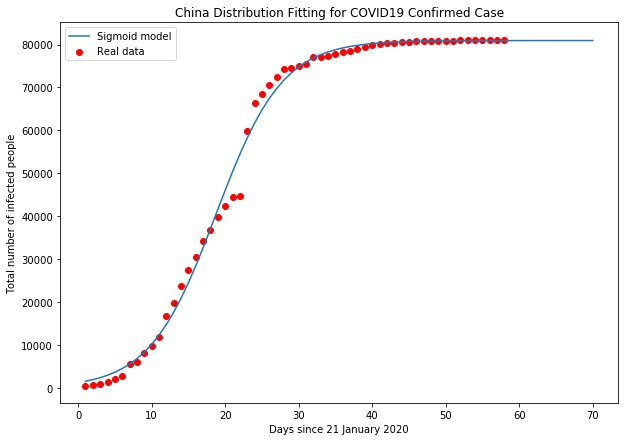

Sigmoid Parameters
Inflextion Speed/Slope: 4.50; Inflextion Day: 18 ; Affected person till saturation: 80936
Standard Errors of estimates : [0.13675607536123635, 0.1581898122902288, 449.9059744842819]


In [10]:
DistributionFitting('China')

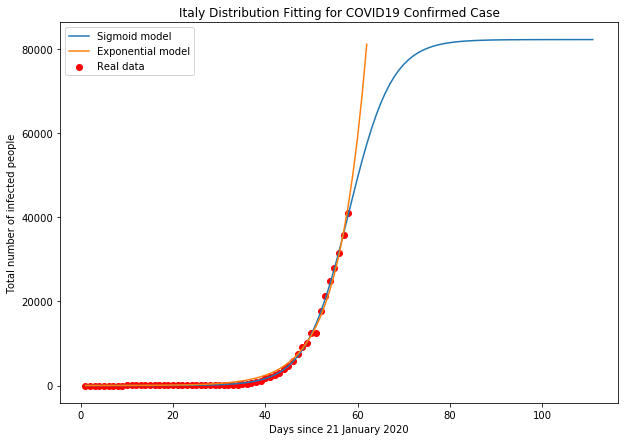

Sigmoid Parameters
Inflextion Speed/Slope: 4.65; Inflextion Day: 58 ; Affected person till saturation: 82198
Standard Errors of estimates : [0.11931053120035173, 0.5635146043658624, 5419.630132270755]

Exponential Parameters
Growth Factor: 0.1594120213205263
Standard Errors of estimates : 0.0029428270694568585


In [11]:
DistributionFitting('Italy', add_function='Exponential')

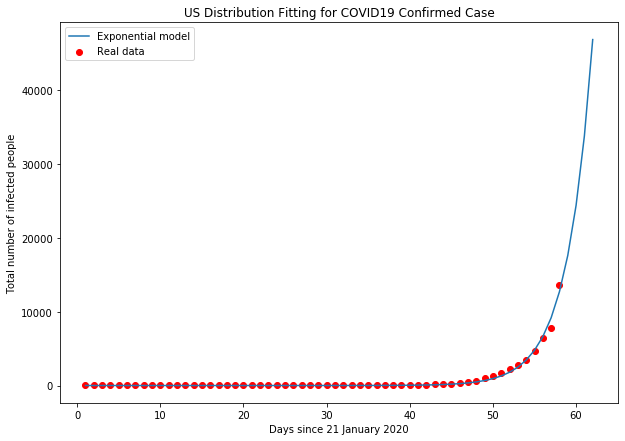


Exponential Parameters
Growth Factor: 0.32618949008937254
Standard Errors of estimates : inf


In [12]:
DistributionFitting('US',add_function='Exponential')

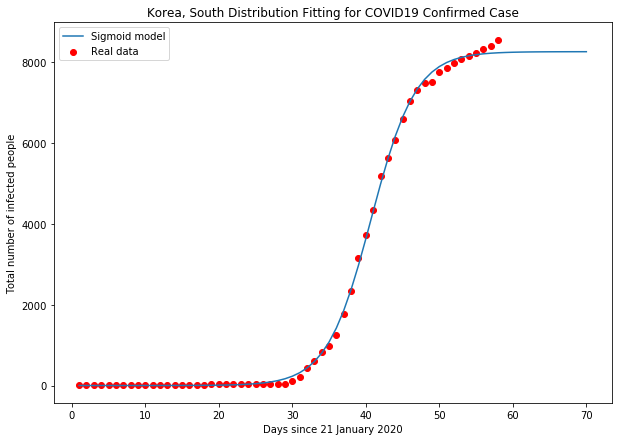

Sigmoid Parameters
Inflextion Speed/Slope: 3.02; Inflextion Day: 40 ; Affected person till saturation: 8265
Standard Errors of estimates : [0.05118042879217625, 0.06148562273741068, 35.19182044170732]


In [14]:
DistributionFitting('Korea, South')

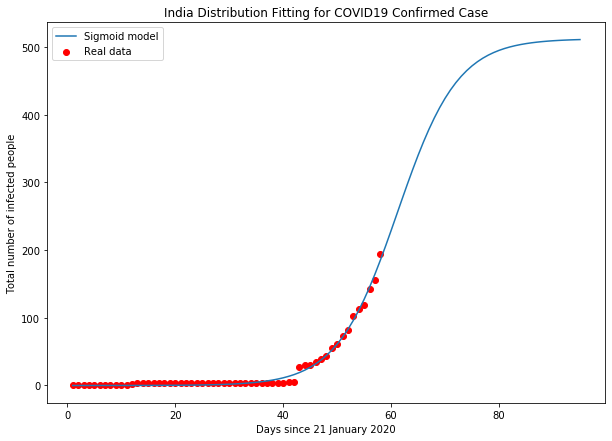

Sigmoid Parameters
Inflextion Speed/Slope: 5.60; Inflextion Day: 61 ; Affected person till saturation: 511
Standard Errors of estimates : [0.3430486685694958, 2.284615956628935, 128.56609455820487]


In [16]:
DistributionFitting('India')

# References
Reference: <br> http://www.engineeringenotes.com/water-engineering-2/water-quantity/forecasting-of-population-9-methods-water-quantity-water-engineering/16158
<br> https://en.wikipedia.org/wiki/Logistic_distribution
<br> https://en.wikipedia.org/wiki/Exponential_growth

# End

In [ ]:
temp = mst_df[mst_df['Country/Region']=='India']
st_dt = pd.to_datetime('2020-01-21', format='%Y-%m-%d')
Days_sinceJan = temp.Date.apply(lambda x: x-st_dt)
temp['Days_sinceJan'] = Days_sinceJan.dt.days

In [ ]:
temp=temp[['Days_sinceJan','Confirmed','New_case']]#.set_index('Days_sinceJan')
temp = pd.DataFrame(temp.groupby(by=['Days_sinceJan']).Confirmed.sum())
# temp = temp.sort_index()
temp.head()

In [ ]:
x=np.array(temp.Confirmed)
y=np.array(temp.index)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(x,y,label="Real data",color="red")
ax.legend()
ax.set_ylabel("Incident days Since 21 Jan")
ax.set_xlabel("Number of Confirmed Case")

In [ ]:
y=np.array(temp.Confirmed)
x=np.array(temp.index)

In [ ]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

fit = curve_fit(logistic_model,x,y,p0=[2,10,500])
fit

In [ ]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
errors

In [ ]:
a,b,c = [x for x in fit[0]]
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
sol

In [ ]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])
exp_fit

In [ ]:
errors = [np.sqrt(exp_fit[1][i][i]) for i in [0,1,2]]
errors

In [ ]:
# pred_x = list(range(max(x),sol))
pred_x = list(range(max(x),sol))
lim = np.unique(list(x)+pred_x)
lim1 = list(x)+list(range(max(x)+1,max(x)+5))
plt.rcParams['figure.figsize'] = [10, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(lim, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in lim], label="Logistic model" )
# Predicted exponential curve
plt.plot(lim1, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in lim1], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 21 January 2020")
plt.ylabel("Total number of infected people")
plt.show()

In [ ]:
y=np.array(temp.Confirmed)
x=np.array(temp.index)

In [ ]:
y

In [ ]:
st.logistic.fit(y,loc=200,scale=100)

In [ ]:
?curve_fit

In [ ]:
plt.figure(figsize=(10,8))
ax = temp.Confirmed.plot(kind='bar')
plt.show()

In [ ]:
def func(x, a, b, c):
  #return a * np.exp(-b * x) + c
  return a * np.log(b * x) + c

x = np.array(temp.New_case)
y = np.array(temp.index)

popt, pcov = scipy.optimize.curve_fit(func, x, y)

In [ ]:
pcov

In [ ]:
def func(x, a, b, c,d):
  #return a * np.exp(-b * x) + c
  return a * np.log(b * x*x +c*x) + d

x = np.array(temp.New_case)
y = np.array(temp.index)

popt, pcov = scipy.optimize.curve_fit(func, x, y)

plt.figure(figsize=(12,6))
plt.plot(x, y, 'ko', label="Original Incident Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()